In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:90%;}
div.text_cell_render.rendered_html{width:90%;}
div.CodeMirror {font-family:Consolas; font-size:19pt;}
div.output {font-size:19pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:18px;}
</style>
"""))

<font size="5" color="red">ch4. 머신러닝 모형 최적화</font>
# 1절. 변수 선택과 차원 축소

# 1-1. 변수 선택과 차원 축소 
- 종속변수에 영향을 주는 변수들만 찾아 학습에 사용할 독립변수의 수를 줄이는 게 목적
- 어떻게 하면 score를 높일 수 있을지가 목적
- 과적합과 독립변수들 사이의 다중공선성을 줄일 수 있음
- 모형의 학습시간을 줄일 수 있음
- 주성분분석, 상관분석, 분류모형의 feature_importance_, SelectKBest.. 등 이용

## 1-2 주성분분석(PCA, Principal Component Anaysis)
- 상관관계가 있는 변수들을 선형결합해서 상관관계가 없는 새로운 변수(주성분)로 축약하는 것

In [6]:
import seaborn as sns
from sklearn.decomposition import PCA
iris = sns.load_dataset('iris')
iris_X, iris_y = iris.iloc[:, :-1], iris.species

pca = PCA(n_components=2) # 주성분의 갯수
pca.fit(iris_X)
iris_pca = pca.transform(iris_X)
iris_pca[::50]

array([[-2.68412563,  0.31939725],
       [ 1.28482569,  0.68516047],
       [ 2.53119273, -0.00984911]])

In [7]:
pca.explained_variance_ # 설명분산:실제변수의 분산값

array([4.22824171, 0.24267075])

In [8]:
# 설명분산을 0~1사이의 비율로 나타낸 값 => 설명정도
pca.explained_variance_ratio_ 

array([0.92461872, 0.05306648])

In [9]:
pca.components_ # 각 주성분의 계수
# x1 = 0.36138659*sl -0.08452251*sw + 0.85667061*pl + 0.3582892*sw

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

In [10]:
iris_X.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

## 1-3 상관관계 확인
- 종속변수와 상관관계가 높은 변수들과 독립변수들끼리의 상관관계를 탐색

In [17]:
import pandas as pd
redwine = pd.read_csv('winequality-red.csv', delimiter=';') #sep=';'
redwine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


cmap : https://matplotlib.org/stable/users/explain/colors/colormaps.html <br>
heatmap : https://seaborn.pydata.org/examples/many_pairwise_correlations.html

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

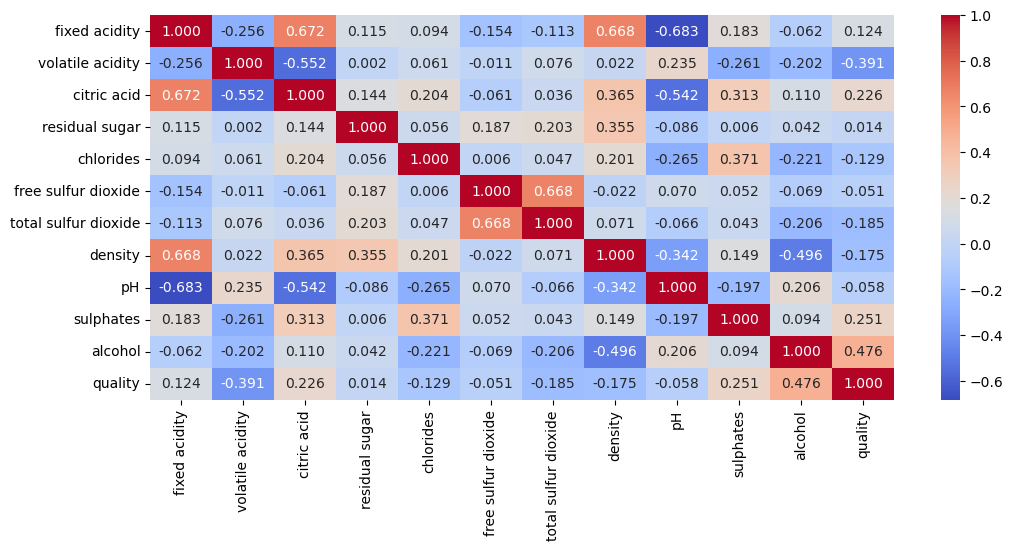

In [22]:
corr = redwine.corr()
plt.figure(figsize=(12,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f')
plt.show()

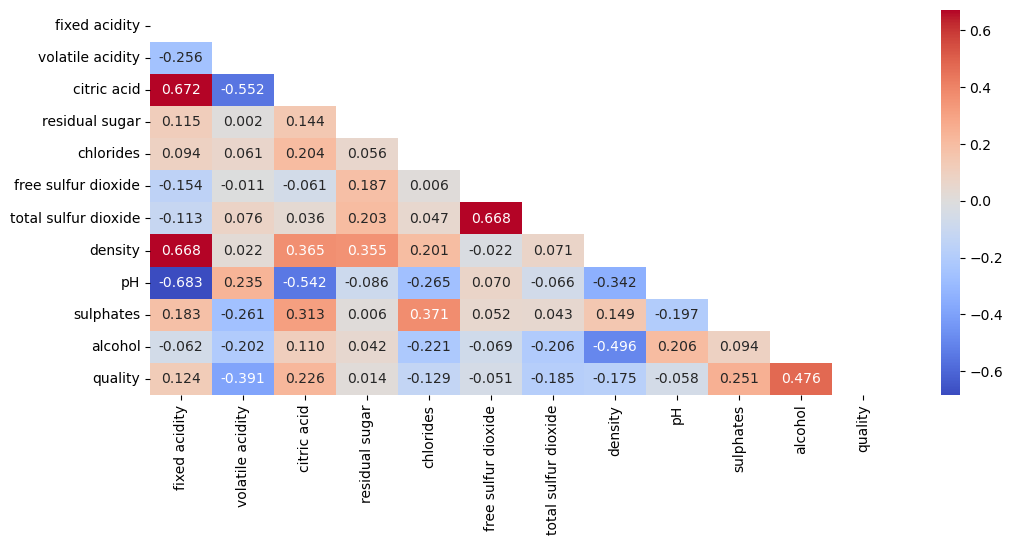

In [23]:
plt.figure(figsize=(12,5))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.3f', mask=mask)
plt.show()

## 1-4 분류모형의 feature_importances_
- 분류모형의 feature_importances_ 속성은 각 독립변수들이 종속변수에 영향을 주는 정도

In [26]:
X = redwine.iloc[:, :-1]
y = redwine.quality
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3)
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((1119, 11), (480, 11), (1119,), (480,))

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=10, #의사결정나무 갯수
                                 random_state=10)
rf_model.fit(train_X, train_y)

RandomForestClassifier(n_estimators=10, random_state=10)

In [36]:
rf_model.feature_importances_

array([0.07283599, 0.10534023, 0.08458888, 0.06511388, 0.082146  ,
       0.07412673, 0.10672823, 0.08727329, 0.07287356, 0.10958644,
       0.13938676])

In [37]:
X.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [43]:
features = pd.DataFrame(data = np.c_[X.columns, rf_model.feature_importances_],
                        columns=['feature','importance'])
features.sort_values(by='importance', ascending=False, inplace=True)
features.reset_index(drop=True, inplace=True)
features.set_index(drop=True, keys='feature')

,importance
feature,
alcohol,0.139387
sulphates,0.109586
total sulfur dioxide,0.106728
volatile acidity,0.10534
density,0.087273
citric acid,0.084589
chlorides,0.082146
free sulfur dioxide,0.074127
pH,0.072874


In [44]:
features

,feature,importance
0,alcohol,0.139387
1,sulphates,0.109586
2,total sulfur dioxide,0.106728
3,volatile acidity,0.10534
4,density,0.087273
5,citric acid,0.084589
6,chlorides,0.082146
7,free sulfur dioxide,0.074127
8,pH,0.072874
9,fixed acidity,0.072836


### feature_importance_를 이용한 변수 중요도 시각화

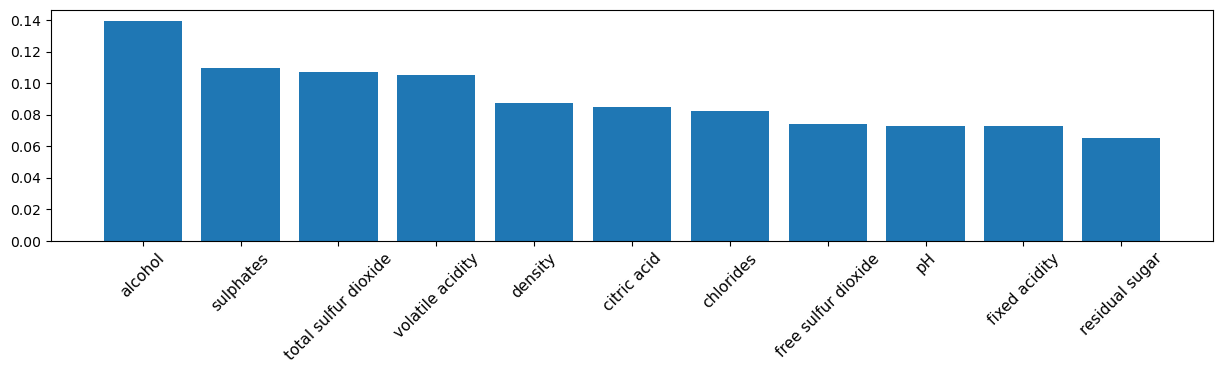

In [50]:
plt.figure(figsize=(15,3))
plt.bar(features.feature, features.importance)
plt.xticks(rotation=45, fontsize=11)
plt.show()

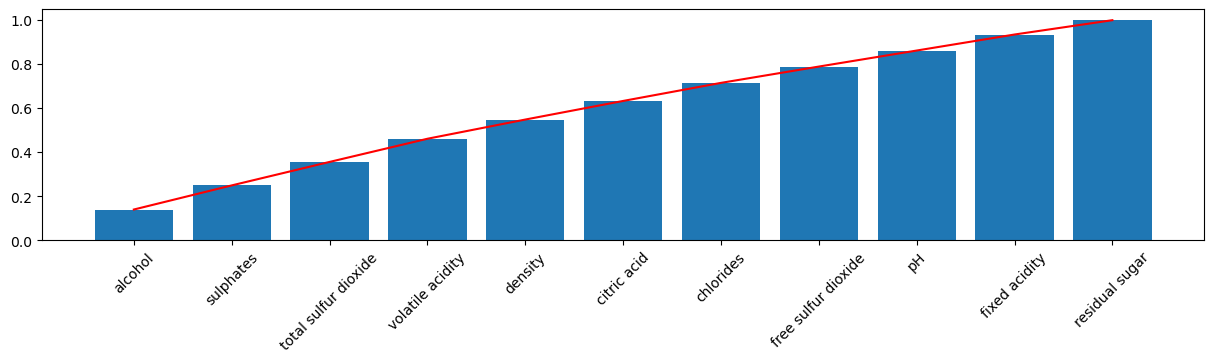

In [58]:
# feature_importance_를 누적한 시각화
y_stack = np.cumsum(features.importance)
plt.figure(figsize=(15,3))
plt.bar(features.feature, y_stack)
plt.plot(features.feature, y_stack, color='red')
plt.xticks(rotation=45)
plt.show()

### RFE(Recursive Feature Elimination) 방식
- RFE클래스를 이용하면 중요도가 낮은 변수부터 하나씩 제거해 나가면서 최종적으로 선택하고자 하는 변수의 개수만큼 중요도가 높은 변수를 찾는다(재귀적 특징 제거)

In [59]:
# feature_importance_에 의해 5개 특징이 남을 때까지 하나씩 제거
# 순위는 모르고 선택된 특징만 알 수 있다
from sklearn.feature_selection import RFE
rfe_model = RFE(RandomForestClassifier(n_estimators=10,
                                      random_state=10),
               n_features_to_select=5)
rfe_model.fit(train_X, train_y)

RFE(estimator=RandomForestClassifier(n_estimators=10, random_state=10),
    n_features_to_select=5)

In [63]:
rfe_model.get_support() # 선택된 변수인지 여부

array([False,  True, False, False, False, False,  True,  True, False,
        True,  True])

In [66]:
X.columns[rfe_model.get_support()] #선택된 변수들

Index(['volatile acidity', 'total sulfur dioxide', 'density', 'sulphates',
       'alcohol'],
      dtype='object')

In [68]:
# 선택된 변수와 선택되지 못한 변수
features_rfe = pd.DataFrame(data=np.c_[X.columns,
                                      rfe_model.get_support()],
                           columns=['feature', 'selected'])
features_rfe.sort_values(by='selected', ascending=False)

,feature,selected
1,volatile acidity,True
6,total sulfur dioxide,True
7,density,True
9,sulphates,True
10,alcohol,True
0,fixed acidity,False
2,citric acid,False
3,residual sugar,False
4,chlorides,False
5,free sulfur dioxide,False


## 1-5 SelectKBest
- 가장 높은 통계 score에 따라 K개 특징 선택

In [75]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, chi2
X, y = load_iris(return_X_y=True)
X.shape, y.shape, y[0]

((150, 4), (150,), 0)

In [81]:
# y는 범주형, X는 연속형일 때 적합한 통계량은 chi2
X_new = SelectKBest(chi2, k=1).fit_transform(X, y)
X_new.shape

(150, 1)

In [82]:
X_new[:2] #petal_length

array([[1.4],
       [1.4]])

# 2절. 파라미터 탐색
- 하이퍼파라미터(사용자가 직접 설정할 수 있는 파라미터)
- 머신러닝 모형이 완성되었을 때 최고의 성능을 내기위한 파라미터 튜닝
- 모형 최적화

## 2-1 validation_curve
- 최적화 할 파라미터 이름과 범위, 성능기준을 각각 param_name, param_range, scoring 인수로 받아
- 모든 경우에 대해 성능을 계산

In [96]:
# 데이터
from sklearn.datasets import load_digits
digits = load_digits()
# digits.data : (1797x64) 크기의 배열
# digits.images : 1797x8x8
# digits.target : (1797,) 크기의 배열 -> 각 data샘플의 숫자0~9
# digits.target_names : 분류될 라벨들
X, y = digits.data, digits.target
X.shape, y.shape

((1797, 64), (1797,))

In [98]:
np.all(digits.data[0].reshape(8,8) == digits.images[0])

True

In [99]:
np.all(digits.data[0] == digits.images[0].ravel())

True

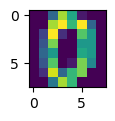

In [91]:
plt.figure(figsize=(1,1))
plt.imshow(digits.images[0])
plt.show()

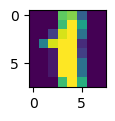

In [102]:
plt.figure(figsize=(1,1))
plt.imshow(X[1].reshape(8,8))
plt.show()

In [103]:
y[1]

1

In [105]:
y[:30]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
       2, 3, 4, 5, 6, 7, 8, 9])

In [107]:
from sklearn.svm import SVC
model = SVC(probability=True).fit(X, y) # SVC가 판별모형이나 probability=True proba 함수 가능

In [109]:
model.predict(X[0].reshape(1, -1))

array([0])

In [110]:
model.predict_proba(X[0].reshape(1, -1))

array([[9.90992474e-01, 2.07731247e-04, 5.00015330e-04, 8.65949698e-04,
        6.78766457e-04, 1.43984671e-03, 7.62081123e-04, 9.00392487e-04,
        7.84552695e-04, 2.86819047e-03]])

In [111]:
model.score(X, y)

0.996661101836394

In [112]:
#  validation_curve 함수를 이용해서 성능이 제일 좋은 파라미터값 도출

In [113]:
# 10의 -6승 ~ 10의 -1승까지 로그간격으로 균등분포 10개 배열로 생성
param_range = np.logspace(-6, -1, 10)
param_range

array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])

In [ ]:
%%time
from sklearn.model_selection import validation_curve
